In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fuzzywuzzy as fuzz
from fuzzywuzzy import process

# Load the data CSVs

In [189]:
# Load full_output.csv
df = pd.read_csv('csv_files/full_output.csv')
df.columns = df.columns.str.strip()

# Drop Event and TEA column
df = df.drop(columns=['Event', 'TEA'])
print(len(df))

# Load pml_output.csv
pml_df = pd.read_csv('csv_files/pml_output.csv')
pml_df.columns = pml_df.columns.str.strip()

60669


# Remove disqualified and null rows

In [190]:
# Remove DNA, DQ
judging_columns = ['Stage Judge 1', 'Stage Judge 2', 'Stage Judge 3', 'Stage Final', 'SR Judge 1', 'SR Judge 2', 'SR Judge 3', 'SR Final']

for i in judging_columns:
    df = df[df[i] != 'DNA']
    df = df[df[i] != 'DQ']

# Convert blanks to nans
for i in judging_columns:
    df[i] = df[i].replace(['', ' '], np.nan)

print(len(df))

60141


In [191]:
# Trim whitespace, double spaces, commas, and periods from selections
selection_columns = ['Selection 1', 'Selection 2', 'Selection 3']

for i in selection_columns:
    df[i] = df[i].str.strip()
    df[i] = df[i].str.replace('  ', ' ', regex=False)
    df[i] = df[i].str.replace(',', '', regex=False)
    df[i] = df[i].str.replace('.', '', regex=False)

# Trim whitespace from classification column
df['Classification'] = df['Classification'].str.strip()

# Remove composer/arranger information from selections
for column in selection_columns:
    # remove all inside parenthesis
    df[column] = df[column].str.replace('\(.*\)', '', regex=True)
    # trim whitespace
    df[column] = df[column].str.strip()


## Get the average judge rating

In [192]:
# Average together Stage Judge 1, 2, and 3 into a new column
for i in judging_columns:
    df[i] = df[i].astype(float)

df['Stage Average'] = (df['Stage Judge 1'] + df['Stage Judge 2'] + df['Stage Judge 3']) / 3

## Export clean csv

In [193]:
# Export df to csv
df.to_csv('csv_files/full_output_clean.csv', index=False)

# Functions for analysis

In [194]:
year_list = df['Year'].unique()
class_list = df['Classification'].unique()
conf_list = df['Conference'].unique()

df['Conference'] = df['Conference'].replace('2C', 'CC')
df['Conference'] = df['Conference'].replace('4A', 'AAAA')
df['Conference'] = df['Conference'].replace('cc', 'CC')
df['Conference'] = df['Conference'].replace('1C', 'C')

print(year_list)
print(class_list)
print(conf_list)


[2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022]
['Varsity' 'Sub Non-Varsity' 'Sub Non-Varsity A' 'Sub Non-Varsity B'
 'Non-Varsity B' 'Non-Varsity C' 'Non-Varsity E' 'Non-Varsity F'
 'Sub Non-Varsity C' 'Sub Non-Varsity D' 'Sub Non-Varsity E' 'Non-Varsity'
 'Non-Varsity A' nan 'Combined' 'Non-Varsity D' 'Var-Composite'
 'Var-Combined' '' 'NVar-Composite' 'NVar-Combined' 'Sub Non-Varsity F'
 'Varsity C' 'Varsity B' 'Varsity A' 'Sub Non-Varsity G' 'Var-Composite A'
 'Sub Non-Varsity H' 'Sub Non-Varsity I' 'NVar-Composite A']
['CC' 'AAAAA' 'AAAA' 'C' 'CCC' 'AAA' 'A' 'AA' 'BBB' 'BB' 'Varsity '
 'Non-Varsity ' 'Non-Varsity A' 'Sub Non-Varsity ' 'Sub Non-Varsity B' 'B'
 'Var-Composite ' '2C' ' Acc:n/a' '4A' 'cc' ' Acc:N/A' 'Non-Varsity C'
 'Var-Combined ' 'NVar-Composite ' '1C' 'AAAAAA']


In [165]:
def top_n_grabber(n=20, d=df, y=year_list, cl=class_list, co=conf_list):
    df_grabber = d
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Year.to_list()).isin(y).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Classification.to_list()).isin(cl).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Conference.to_list()).isin(co).any(1).values]

    # Select each Selection into a list
    selection_1_list = df_grabber['Selection 1'].tolist()
    selection_2_list = df_grabber['Selection 2'].tolist()
    selection_3_list = df_grabber['Selection 3'].tolist()
    # combine selection 1, 2, and 3 into one dataframe
    full_selection_list = pd.DataFrame(selection_1_list + selection_2_list + selection_3_list)

    top_n_df = pd.DataFrame(full_selection_list.value_counts()[:n])
    top_n_df.columns = ['Count']
    top_n_df.reset_index(drop=False, inplace=True)
    top_n_df.columns = ['Selection', 'Count']
    top_n_df

    # make selection column into a list
    selection_list = top_n_df['Selection'].tolist()
    value_list = top_n_df['Count'].tolist()
    return selection_list, value_list

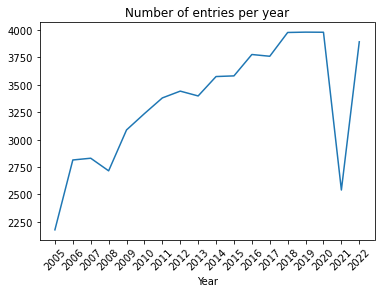

In [195]:
# Plot a line graph of the number of rows in each year
df_year_counter = df.groupby('Year').size()
df_year_counter.plot(kind='line')
plt.xticks(year_list)
plt.xticks(rotation=45)
plt.title('Number of entries per year')
plt.show()

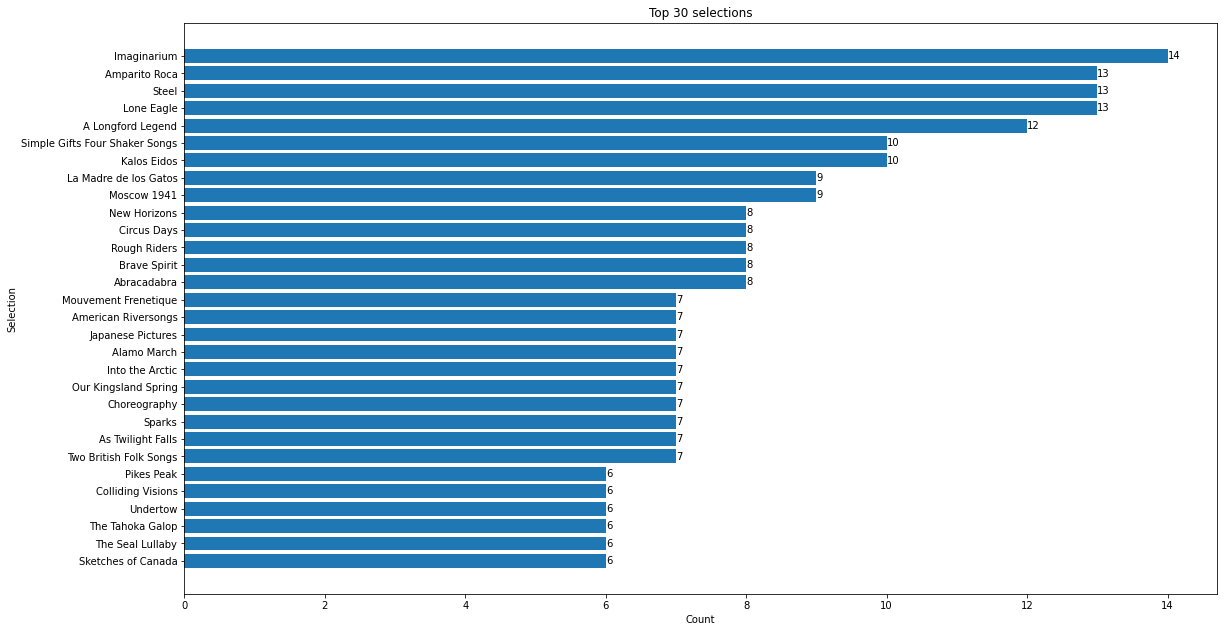

In [197]:

# Plot top n selections
def plotter(n=20, d=df, y=year_list, cl=class_list, co=conf_list):
    fig, ax = plt.subplots()
    bars = ax.barh(top_n_grabber(n, d, y, cl, co)[0], top_n_grabber(n, d, y, cl, co)[1])
    ax.set_title(f'Top {n} selections')
    ax.set_xlabel('Count')
    ax.set_ylabel('Selection')
    for bars in ax.containers:
        ax.bar_label(bars)
    # invert the y-axis
    ax.invert_yaxis()
   # reset size of the plot
    fig.set_size_inches(18.5, 10.5)

    plt.show()

plotter(30, df, [2022], ['Non-Varsity'], ['AAAAAA', 'AAAAA'])

# Find Rows by Selection Title

In [199]:
# Combine all rows where any selection contains the search term
def selection_finder(selection, d=df, y=year_list, cl=class_list, co=conf_list):
    df_grabber = d
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Year.to_list()).isin(y).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Classification.to_list()).isin(cl).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Conference.to_list()).isin(co).any(1).values]
    finder_df = df[(df['Selection 1'].str.contains(selection)) | (df['Selection 2'].str.contains(selection)) | (df['Selection 3'].str.contains(selection))]
    return finder_df

selection = 'Melody Shop'

selection_finder_df = selection_finder(selection, df, [2022], class_list, conf_list)
selection_finder_df

,Unnamed: 0,School,City,Directors,Conference,Classification,Year,ID,Stage Judge 1,Stage Judge 2,...,Stage Final,SR Judge 1,SR Judge 2,SR Judge 3,SR Final,Award,Selection 1,Selection 2,Selection 3,Stage Average
64,29696,McCallum High School,Austin,Carol Nelson,AAAA,Varsity,2005,13924,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,SWA,The Melody Shop,Push,Mars,1.000000
101,29550,Victoria Memorial High School,Victoria,Phillip J. Mikula,AAAAA,Varsity,2005,17593,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,RMA,The Melody Shop March,A Hymn for The Lost And The Living,Niagara Falls,1.000000
1351,30229,Sherman High School,Sherman,Jeff Bradford,AAAA,Varsity,2005,13116,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,SW,Fantasies on a Theme by Haydn,La Procession du Rocio,The Melody Shop,1.000000
2762,32006,Birdville High School,North Richland Hills,Brian Gibbs/Paul Heuer/Dwayne Rice,AAAA,Varsity,2006,22335,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,RMA,The Melody Shop March,Buckaroo Holiday from Rodeo,Rocky Point Holiday,1.000000
2828,31793,Lake Highlands High School,Dallas,Joshua Blankenship,AAAAA,Varsity,2006,21634,2.0,2.0,...,2.0,1.0,1.0,1.0,1.0,,Symphonic Metamorphosis,When Jesus Wept,The Melody Shop,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59212,54520,Legacy High School,Mansfield,"Andrew Nance / Christopher Monasmith, Chris V...",AAAAA,Varsity,2022,176326,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Elsas Procession to the Cathedral,The Speed of Heat,1.000000
59324,54368,Lake Travis High School,Austin,"Richard Hicks / Taylor Trevino, Lance Brightw...",AAAAAA,Varsity,2022,176168,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Frozen Cathedral,Symphonie Fantastique - Dream of a Witches Sab...,1.000000
59698,53788,Foster High School,Richmond,"Erich Sonnier / Brian Allmond, Jeremiah Salis...",AAAAA,Varsity,2022,177627,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Ride,Acadiana,1.000000
59933,18762,Round Rock High School,Round Rock,Brittany Graham / Steve Roeder,AAAAAA,Non-Varsity,2022,174111,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,C,The Melody Shop,O Magnum Mysterium,Until the Scars,1.000000


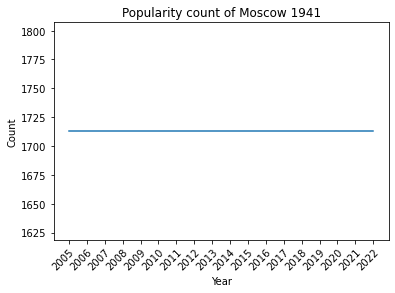

In [185]:
selection = 'Moscow 1941'
yearly_count_values = []
selection_finder_df = df

for y in year_list:
    selection_finder_df = selection_finder(selection, d=selection_finder_df, y=[y], cl=class_list, co=conf_list)
    yearly_count_values.append(len(selection_finder_df))

# make a line graph of the yearly count of selections
def yearly_count_plotter(yearly_count_values):
    fig, ax = plt.subplots()
    ax.plot(yearly_count_values)
    ax.set_title(f'Popularity count of {selection}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    # set number of ticks on x-axis to match len(year_list)
    ax.set_xticks(range(len(year_list)))
    # set x labels to year_list
    ax.set_xticklabels(year_list)
    # rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

yearly_count_plotter(yearly_count_values)

# Find Rows by Directors

In [ ]:
def director_finder(director, df):
    finder_df = df[df['Directors'].str.contains(director)]
    return finder_df

director = 'Kevin MacDonald'
df_for_search = df

director_finder_df = director_finder(director, df_for_search)
director_finder_df.sort_values(by='Stage Average', ascending=False)

In [ ]:
director_score = director_finder_df['Stage Average'].mean()
director_score

# Get the UIL ID for each selection

In [ ]:
# combine the pml_df columns title and composer into a single column
pml_df['Full Selection'] = pml_df['Title'] + ' - ' + pml_df['Composer']

# Saved cells for reference

## Cleaning the selections

In [ ]:
# Make a single list containing all unique selections

# Select all 'Selection 1' rows as a list
selection_1_list = df['Selection 1'].tolist()
# Select all 'Selection 2' rows
selection_2_list = df['Selection 2'].tolist()
# Select all 'Selection 3' rows
selection_3_list = df['Selection 3'].tolist()
# combine selection 1, 2, and 3 into one list
full_selection_df = pd.DataFrame(selection_1_list + selection_2_list + selection_3_list)

# Drop duplicates and export as list
full_selection_df = full_selection_df.drop_duplicates()
full_selection_list = full_selection_df[0].tolist()
len(full_selection_list)

In [ ]:
# Move text within parentheses to a new column
full_selection_list['Selection Name'] = full_selection_list['Full Selection'].str.extract(r'(.*?)\(.*?\)')
# Take full selection and move text within parentheses to a new column
full_selection_list['Composer Name'] = full_selection_list['Full Selection'].str.extract(r'\((.*)\)')
full_selection_list


In [20]:
df.dtypes

Unnamed: 0          int64
School             object
City               object
Directors          object
Conference         object
Classification     object
Year                int64
ID                  int64
Stage Judge 1     float64
Stage Judge 2     float64
Stage Judge 3     float64
Stage Final       float64
SR Judge 1        float64
SR Judge 2        float64
SR Judge 3        float64
SR Final          float64
Award              object
Selection 1        object
Selection 2        object
Selection 3        object
Stage Average     float64
dtype: object

In [ ]:
# Create a new column to fuzzy match df['Selection 1'] to pml_df['Full Selection']
#df['Selection 1 Match'] = df['Selection 1'].apply(lambda x: process.extractOne(x, pml_df['Full Selection'])[0])
#df['Selection 2 Match'] = df['Selection 2'].apply(lambda x: process.extractOne(x, pml_df['Full Selection'])[0]) 
#df['Selection 3 Match'] = df['Selection 3'].apply(lambda x: process.extractOne(x, pml_df['Full Selection'])[0])